In [15]:
"""
The function `torch_conv_layer_to_affine` takes a `torch.nn.Conv2d` layer `conv`
and produces an equivalent `torch.nn.Linear` layer `fc`.
Specifically, this means that the following holds for `x` of a valid shape:
    torch.flatten(conv(x)) == fc(torch.flatten(x))
Or equivalently:
    conv(x) == fc(torch.flatten(x)).reshape(conv(x).shape)
allowing of course for some floating-point error.
"""
from typing import Tuple
import torch
import torch.nn as nn
import numpy as np
def torch_conv_layer_to_affine(
    conv: torch.nn.Conv2d, input_size: Tuple[int, int]
) -> torch.nn.Linear:
    w, h = input_size
    # Formula from the Torch docs:
    # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    output_size = [
            (input_size[i] + 2 * conv.padding[i] - conv.kernel_size[i]) // conv.stride[i]
    + 1
    for i in [0, 1]
        ]
    
    in_shape = (conv.in_channels, w, h)
    out_shape = (conv.out_channels, output_size[0], output_size[1])
    fc = nn.Linear(in_features=np.product(in_shape), out_features=np.product(out_shape))
    fc.weight.data.fill_(0.0)

    # Output coordinates
    for xo, yo in range2d(output_size[0], output_size[1]):
        # The upper-left corner of the filter in the input tensor
        xi0 = -conv.padding[0] + conv.stride[0] * xo
        yi0 = -conv.padding[1] + conv.stride[1] * yo
        # Position within the filter
        for xd, yd in range2d(conv.kernel_size[0], conv.kernel_size[1]):
            # Output channel
            for co in range(conv.out_channels):
                fc.bias[enc_tuple((co, xo, yo), out_shape)] = conv.bias[co]
                for ci in range(conv.in_channels):
                    # Make sure we are within the input image (and not in the padding)
                    if 0 <= xi0 + xd < w and 0 <= yi0 + yd < h:
                        cw = conv.weight[co, ci, xd, yd]
                        # Flatten the weight position to 1d in "canonical ordering",
                        # i.e. guaranteeing that:
                        # FC(img.reshape(-1)) == Conv(img).reshape(-1)
                        fc.weight[
                        enc_tuple((co, xo, yo), out_shape),
                        enc_tuple((ci, xi0 + xd, yi0 + yd), in_shape),
                                                ] = cw
    return fc

def range2d(to_a, to_b):
    for a in range(to_a):
        for b in range(to_b):
            yield a, b

def enc_tuple(tup: Tuple, shape: Tuple) -> int:
    res = 0
    coef = 1
    for i in reversed(range(len(shape))):
        assert tup[i] < shape[i]
        res += coef * tup[i]
        coef *= shape[i]
    return res

def dec_tuple(x: int, shape: Tuple) -> Tuple:
    res = []
    for i in reversed(range(len(shape))):
        res.append(x % shape[i])
        x //= shape[i]
        return tuple(reversed(res))

def test_tuple_encoding():
    x = enc_tuple((3, 2, 1), (5, 6, 7))
    assert dec_tuple(x, (5, 6, 7)) == (3, 2, 1)
    print("Tuple encoding ok")

def test_layer_conversion():
    for stride in [1, 2]:
        for padding in [0, 1, 2]:
            for filter_size in [3, 4]:
                img = torch.rand((1, 2, 6, 7))
                conv = nn.Conv2d(2, 5, filter_size, stride=stride, padding=padding)
                fc = torch_conv_layer_to_affine(conv, img.shape[2:])
                # Also checks that our encoding flattens the inputs/outputs such that
                # FC(flatten(img)) == flatten(Conv(img))
                res1 = fc(img.reshape((-1))).reshape(conv(img).shape)
                res2 = conv(img)
                worst_error = (res1 - res2).max()
                print("Output shape", res2.shape, "Worst error: ", float(worst_error))
                assert worst_error <= 1.0e-6
                print("Layer conversion ok")

In [16]:
import cv2
import torch
import torchvision
import numpy as np
import utils

import torchvision.transforms.functional

In [17]:
img = np.array(cv2.imread('images/castle.jpg'))[...,::-1]/255.0

# values from https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [18]:
model = torchvision.models.vgg16(pretrained=True)
model.eval()

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [19]:
Xnp = X.detach().cpu().numpy()

In [20]:
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

In [21]:
A = [Xnp]

for layer in layers:
    print(layer)
    if type(layer).__name__ == "Conv2d":
        kernel_size = layer.kernel_size
        H = A[-1].shape[2]
        W = A[-1].shape[3]
        C_out = layer.out_channels
        padding = layer.padding
        weights = layer.weight.detach().cpu().numpy()
        biases = layer.bias.detach().cpu().numpy()

        A_pad = np.array([[
            np.pad(x, padding, 'constant', constant_values=(0, 0)) for x in A[-1][0]]])

        H_out = H - kernel_size[0] + 2*padding[0] + 1
        W_out = W - kernel_size[1] + 2*padding[1] + 1
        output = np.zeros((1, C_out, H_out, W_out))
        
        for k in range(C_out):
            kernel = weights[k]

            for i in range(H_out):
                for j in range(W_out):
                    zone = A_pad[0,:,i:i+kernel_size[0],j:j+kernel_size[1]]
                    product = np.tensordot(zone, kernel, axes=3)
                    result = product + biases[k]
                    output[0,k,i,j] = result
        A.append(output)

    elif type(layer).__name__ == "ReLU":
        relu = lambda x: np.maximum(x, 0)
        A.append(relu(output))
    
    elif type(layer).__name__ == "MaxPool2d":
        break

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


do LRP using gradient for everything but the first layer and try to do the first layer by hand

In [22]:
A = [X]+[None]*L
for l in range(L):
    A[l+1] = layers[l].forward(A[l])
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))
R_simp = [None]*L + [(A[-1]*T).data]

In [58]:
for l in range(0,L)[::-1]:
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):
        
        if l == 0:
            rho = lambda p: p
            incr = lambda z: z+1e-9
        elif l <= 16:
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30:
            rho = lambda p: p
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))
        s = (R_simp[l+1]/z).data
        (z*s).sum().backward()
        c = A[l].grad
        R_simp[l] = (A[l]*c).data
        R_simp[l] = R_simp[l]
        
    else:
        R_simp[l] = R_simp[l+1]

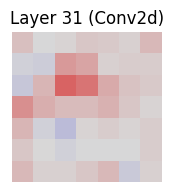

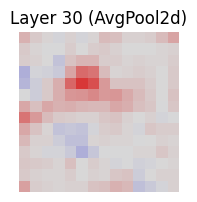

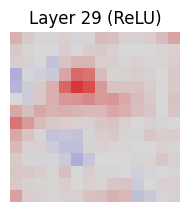

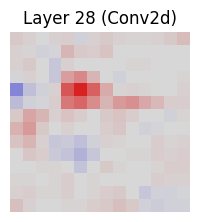

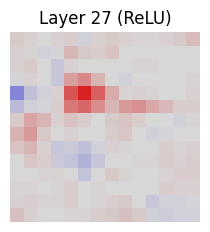

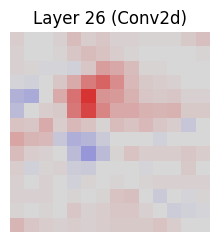

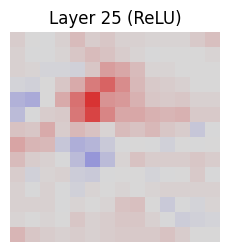

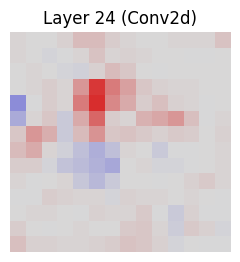

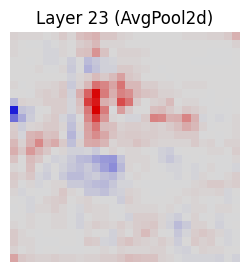

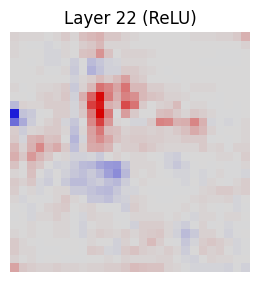

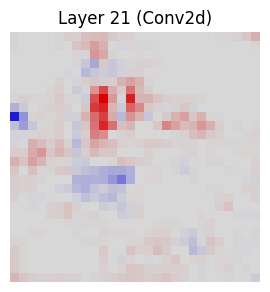

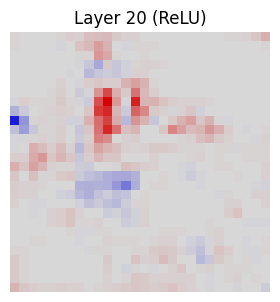

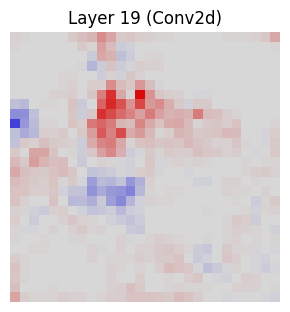

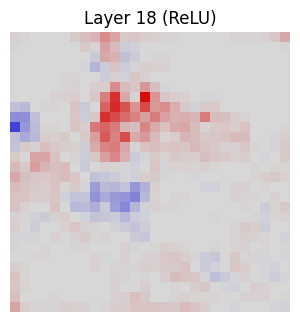

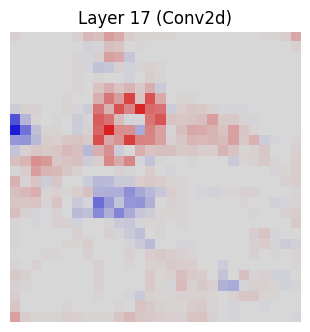

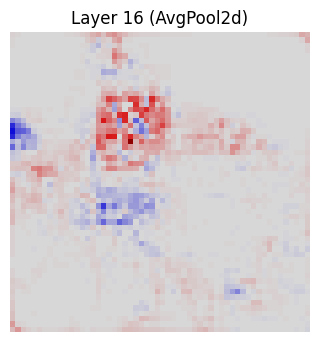

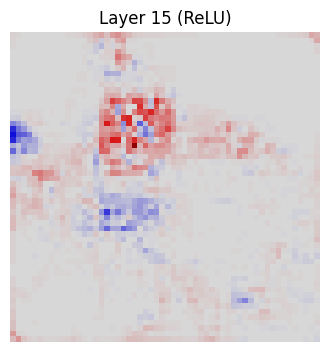

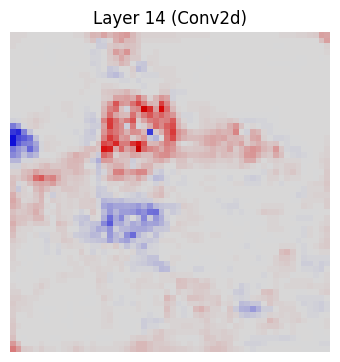

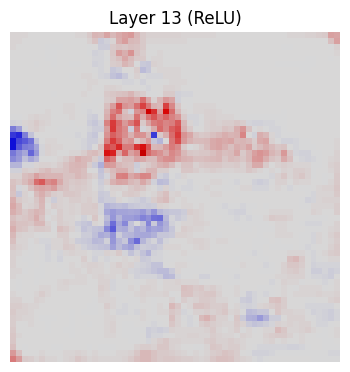

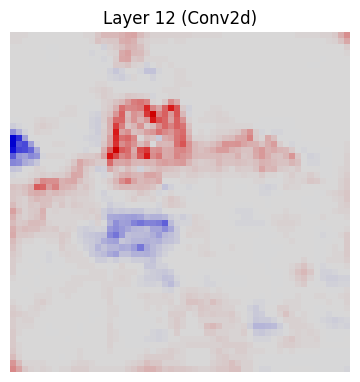

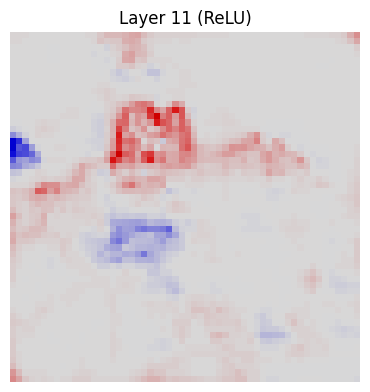

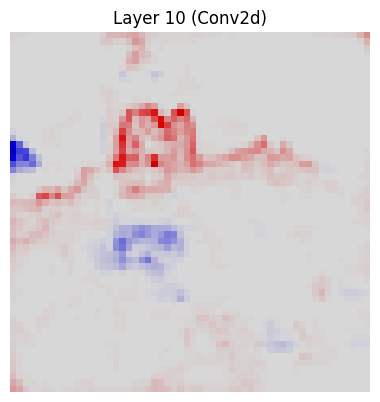

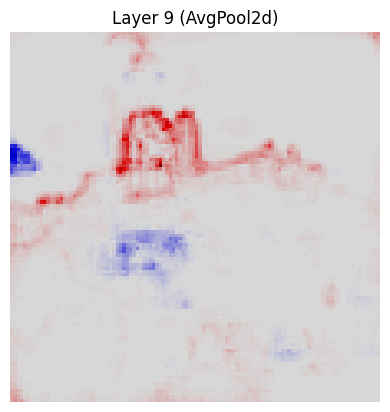

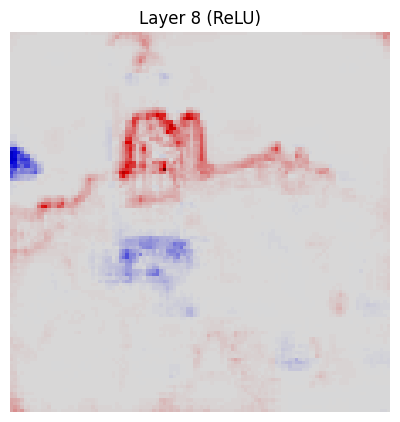

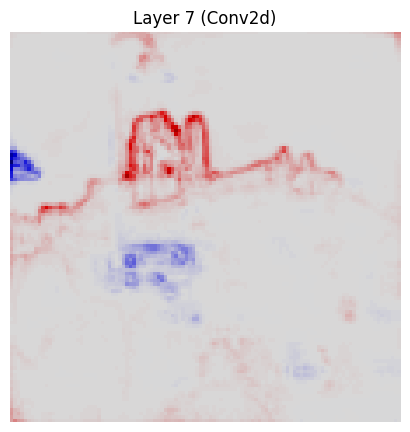

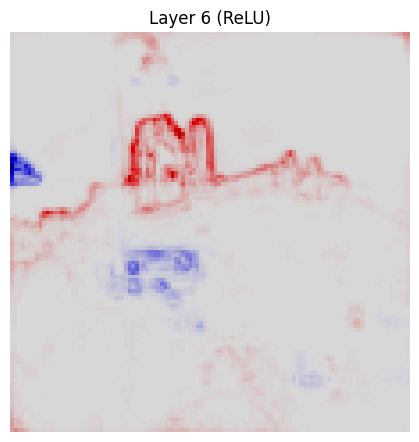

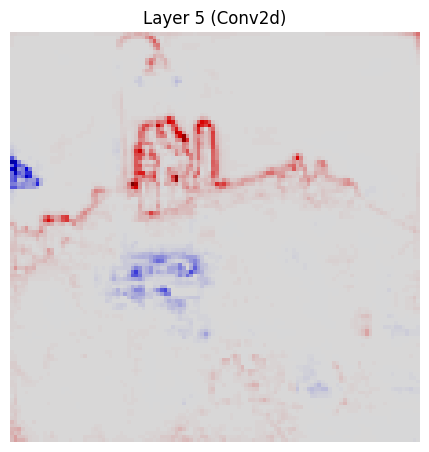

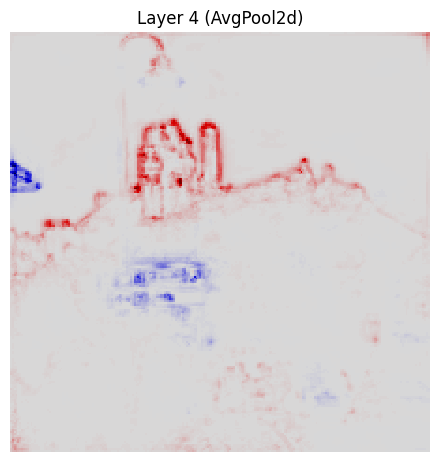

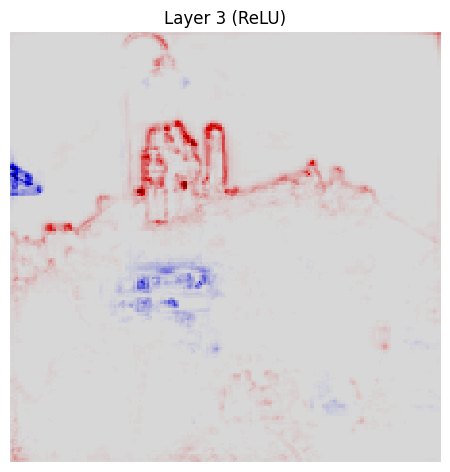

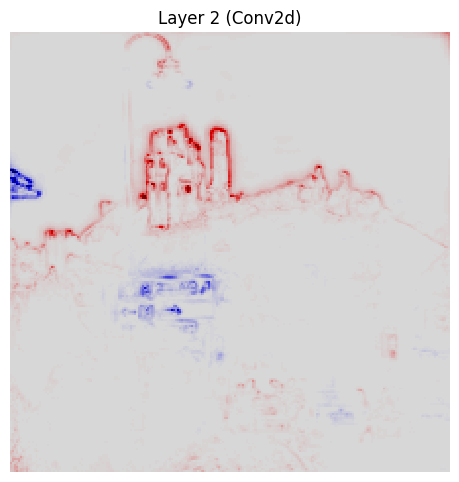

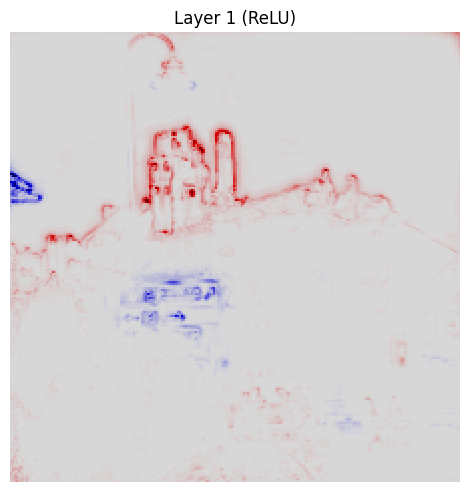

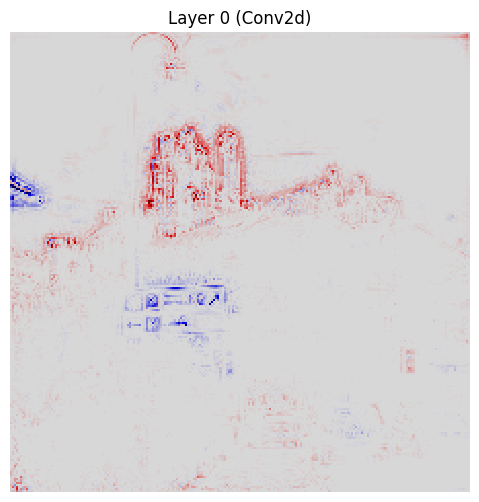

In [59]:
for i,l in enumerate(range(31, 0-1, -1)):
    utils.heatmap(np.array(R_simp[l][0]).sum(axis=0),0.1*i+1.5,0.1*i+1.5, title=f"Layer {l} ({type(layers[l]).__name__})")